In [6]:
# ===== Standard Library =====
import os
import shutil
import random
import multiprocessing

# ===== Scientific Stack =====
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns

# ===== PyTorch / TorchVision =====
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader, ConcatDataset
from torchvision import transforms, models
from torchvision.transforms import functional as TF

from torch.optim.lr_scheduler import ReduceLROnPlateau, CosineAnnealingLR

# ===== scikit-learn =====
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_auc_score,
)

# ===== Colab (optional) =====
from google.colab import drive


In [7]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
# Step 2: Define paths (edit these if needed)
zip_path = "/content/drive/MyDrive/yolo_cropping_dataset.zip"  # <-- change this if your file is in a folder
extract_dir = "/content/"

# Step 3: Unzip the dataset
import zipfile

os.makedirs(extract_dir, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

In [9]:
# === Set up paths ===
base_path = "/content/train"
image_dir = os.path.join(base_path, "images")
label_dir = os.path.join(base_path, "labels")

# Destination folders
train_img_dst = "/content/dataset/train/images"
train_lbl_dst = "/content/dataset/train/labels"
val_img_dst = "/content/dataset/valid/images"
val_lbl_dst = "/content/dataset/valid/labels"

# Create folders
os.makedirs(train_img_dst, exist_ok=True)
os.makedirs(train_lbl_dst, exist_ok=True)
os.makedirs(val_img_dst, exist_ok=True)
os.makedirs(val_lbl_dst, exist_ok=True)

# === Get all image files ===
image_files = sorted([f for f in os.listdir(image_dir) if f.endswith((".jpg", ".png"))])

# === Split ===
train_imgs, val_imgs = train_test_split(image_files, test_size=0.2, random_state=42)

# === Move files ===
def move_split(files, img_dst, lbl_dst):
    for img_file in files:
        label_file = img_file.rsplit(".", 1)[0] + ".txt"
        # Copy image
        shutil.copy(os.path.join(image_dir, img_file), os.path.join(img_dst, img_file))
        # Copy label
        shutil.copy(os.path.join(label_dir, label_file), os.path.join(lbl_dst, label_file))

# Apply split
move_split(train_imgs, train_img_dst, train_lbl_dst)
move_split(val_imgs, val_img_dst, val_lbl_dst)

# print(f"✅ Split complete: {len(train_imgs)} train / {len(val_imgs)} valid images.")

In [10]:
import os
from PIL import Image

image_folder = "/content/dataset/train/images"  # Or wherever your images are

widths = []
heights = []

image_files = [f for f in os.listdir(image_folder) if f.endswith((".jpg", ".png"))]

for file in image_files:
    with Image.open(os.path.join(image_folder, file)) as img:
        w, h = img.size
        widths.append(w)
        heights.append(h)

print(f"Total images checked: {len(widths)}")
print(f"Min size: {min(widths)} x {min(heights)}")
print(f"Max size: {max(widths)} x {max(heights)}")
print(f"Avg size: {sum(widths)//len(widths)} x {sum(heights)//len(heights)}")


Total images checked: 80
Min size: 720 x 480
Max size: 1920 x 1080
Avg size: 780 x 510


In [11]:
!pip install ultralytics


In [12]:
from ultralytics import YOLO

# Load the base model (Nano or Small recommended for fast training)
model = YOLO("yolov8n.pt")  # or use "yolov8s.pt" for more accuracy


In [13]:
!find /content -name "data.yaml"


/content/dataset/data.yaml
/content/data.yaml


In [14]:
!mv /content/data.yaml /content/dataset/data.yaml


In [15]:
from ultralytics import YOLO

model = YOLO("yolov8n.pt")  # or yolov8s.pt for more accuracy

model.train(
    data="/content/dataset/data.yaml",
    epochs=50,
    imgsz=640,
    batch=8,
    name="pupil_detector_v1"
)


Ultralytics 8.3.177 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/dataset/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=pupil_detector_v13, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0,

train: Scanning /content/train/labels.cache... 100 images, 0 backgrounds, 0 corrupt: 100%|██████████| 100/100 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 310.5±72.6 MB/s, size: 38.3 KB)


val: Scanning /content/dataset/valid/labels.cache... 20 images, 0 backgrounds, 0 corrupt: 100%|██████████| 20/20 [00:00<?, ?it/s]


Plotting labels to runs/detect/pupil_detector_v13/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/pupil_detector_v13
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      1.34G      1.312      2.925      1.569          5        640: 100%|██████████| 13/13 [00:01<00:00, 10.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 16.70it/s]

                   all         20         20    0.00333          1      0.913      0.676



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      1.34G     0.8756      1.468      1.139         11        640: 100%|██████████| 13/13 [00:01<00:00, 11.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 17.99it/s]

                   all         20         20          1      0.227      0.925      0.668



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      1.34G     0.8182      1.124      1.118         14        640: 100%|██████████| 13/13 [00:01<00:00, 12.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 17.55it/s]

                   all         20         20          1      0.748       0.99      0.768



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      1.34G     0.8687      1.094      1.138         13        640: 100%|██████████| 13/13 [00:00<00:00, 13.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 16.77it/s]

                   all         20         20      0.991          1      0.995      0.812



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      1.34G     0.7709      1.051      1.117         13        640: 100%|██████████| 13/13 [00:00<00:00, 13.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 17.68it/s]

                   all         20         20      0.952      0.993       0.99      0.833



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      1.34G     0.8026       1.08      1.102          8        640: 100%|██████████| 13/13 [00:00<00:00, 13.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 17.92it/s]

                   all         20         20      0.948       0.95       0.99      0.735



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      1.34G     0.8375      1.065      1.112          9        640: 100%|██████████| 13/13 [00:00<00:00, 13.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 17.21it/s]

                   all         20         20      0.993       0.95       0.99      0.815



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      1.34G     0.8448      1.078      1.127         13        640: 100%|██████████| 13/13 [00:00<00:00, 14.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 17.83it/s]

                   all         20         20      0.994          1      0.995      0.828



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      1.34G     0.8188       1.03      1.103          5        640: 100%|██████████| 13/13 [00:00<00:00, 13.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 17.23it/s]

                   all         20         20          1      0.997      0.995       0.79



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      1.34G     0.7554     0.9613      1.056         12        640: 100%|██████████| 13/13 [00:00<00:00, 13.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 16.03it/s]

                   all         20         20      0.947       0.95      0.985      0.803



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      1.34G     0.7852     0.9267      1.052          6        640: 100%|██████████| 13/13 [00:00<00:00, 13.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 17.87it/s]

                   all         20         20      0.994          1      0.995      0.799



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      1.34G     0.8332     0.9637      1.104         10        640: 100%|██████████| 13/13 [00:00<00:00, 13.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 17.27it/s]

                   all         20         20      0.981          1      0.995      0.848



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      1.34G     0.7066     0.8177      1.035          9        640: 100%|██████████| 13/13 [00:00<00:00, 14.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 16.27it/s]


                   all         20         20          1      0.947      0.988      0.847

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      1.34G     0.7663     0.8133       1.07          9        640: 100%|██████████| 13/13 [00:00<00:00, 13.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 16.70it/s]

                   all         20         20      0.945          1      0.995      0.754



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      1.34G     0.7263     0.7562      1.028         13        640: 100%|██████████| 13/13 [00:00<00:00, 13.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 16.26it/s]

                   all         20         20      0.905          1      0.985      0.836



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      1.34G     0.6724     0.7539      1.026          5        640: 100%|██████████| 13/13 [00:00<00:00, 13.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 17.85it/s]

                   all         20         20      0.988          1      0.995      0.868



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      1.34G     0.6911      0.726      1.017         10        640: 100%|██████████| 13/13 [00:00<00:00, 13.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 17.79it/s]

                   all         20         20      0.995          1      0.995      0.867



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      1.34G     0.6789     0.6994      1.031         12        640: 100%|██████████| 13/13 [00:00<00:00, 13.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 18.19it/s]


                   all         20         20      0.995          1      0.995      0.892

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      1.34G     0.6625      0.669      1.006         13        640: 100%|██████████| 13/13 [00:00<00:00, 13.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 17.66it/s]


                   all         20         20      0.996          1      0.995      0.891

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      1.34G      0.642     0.7087      1.018          9        640: 100%|██████████| 13/13 [00:01<00:00, 12.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 17.61it/s]

                   all         20         20      0.996          1      0.995       0.87



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      1.34G     0.6305     0.6378      1.008          9        640: 100%|██████████| 13/13 [00:00<00:00, 13.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 17.94it/s]

                   all         20         20      0.996          1      0.995      0.866



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      1.34G     0.6609     0.6473      1.007          9        640: 100%|██████████| 13/13 [00:00<00:00, 13.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 17.94it/s]

                   all         20         20      0.997          1      0.995      0.882



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      1.34G     0.6395     0.6161     0.9999          6        640: 100%|██████████| 13/13 [00:00<00:00, 13.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 17.32it/s]

                   all         20         20      0.997          1      0.995      0.857



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      1.34G     0.6473     0.5835      1.004         12        640: 100%|██████████| 13/13 [00:00<00:00, 14.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 17.70it/s]

                   all         20         20      0.997          1      0.995        0.9



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      1.34G     0.6152      0.604     0.9795          8        640: 100%|██████████| 13/13 [00:00<00:00, 13.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 17.98it/s]

                   all         20         20      0.997          1      0.995        0.9



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      1.34G     0.5841     0.5686     0.9742         13        640: 100%|██████████| 13/13 [00:00<00:00, 13.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 15.28it/s]

                   all         20         20      0.997          1      0.995      0.898



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      1.34G      0.613     0.5563     0.9492         10        640: 100%|██████████| 13/13 [00:00<00:00, 13.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 18.35it/s]


                   all         20         20      0.997          1      0.995      0.889

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      1.34G     0.6201     0.5584     0.9739          9        640: 100%|██████████| 13/13 [00:00<00:00, 13.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 15.74it/s]

                   all         20         20      0.997          1      0.995      0.907



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      1.34G     0.6206     0.5563     0.9966          8        640: 100%|██████████| 13/13 [00:00<00:00, 13.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 17.93it/s]


                   all         20         20      0.997          1      0.995      0.914

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      1.34G     0.5937     0.5495      0.966         11        640: 100%|██████████| 13/13 [00:00<00:00, 13.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 18.31it/s]


                   all         20         20      0.997          1      0.995        0.9

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      1.34G     0.5709     0.5687     0.9799          6        640: 100%|██████████| 13/13 [00:00<00:00, 13.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 17.25it/s]

                   all         20         20      0.997          1      0.995       0.92



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      1.34G     0.6159     0.5471     0.9905         12        640: 100%|██████████| 13/13 [00:00<00:00, 13.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 18.62it/s]

                   all         20         20      0.997          1      0.995      0.913



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      1.34G     0.6177     0.5395     0.9901          7        640: 100%|██████████| 13/13 [00:00<00:00, 13.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 17.78it/s]

                   all         20         20      0.997          1      0.995       0.91



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      1.34G      0.577     0.5114     0.9785         14        640: 100%|██████████| 13/13 [00:00<00:00, 13.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 17.28it/s]

                   all         20         20      0.997          1      0.995      0.902



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      1.34G     0.5898     0.4885     0.9606          7        640: 100%|██████████| 13/13 [00:00<00:00, 13.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 17.38it/s]

                   all         20         20      0.997          1      0.995      0.915



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      1.34G     0.5628      0.511     0.9825         11        640: 100%|██████████| 13/13 [00:00<00:00, 13.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 15.97it/s]

                   all         20         20      0.997          1      0.995      0.923



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      1.34G     0.5645     0.4863     0.9613         11        640: 100%|██████████| 13/13 [00:00<00:00, 14.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 18.84it/s]

                   all         20         20      0.997          1      0.995      0.907



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      1.34G     0.5546     0.4865     0.9744         10        640: 100%|██████████| 13/13 [00:01<00:00, 12.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 18.34it/s]

                   all         20         20      0.997          1      0.995      0.893



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      1.34G     0.5413     0.4912     0.9793          6        640: 100%|██████████| 13/13 [00:00<00:00, 13.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 18.06it/s]

                   all         20         20      0.998          1      0.995      0.908



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      1.34G     0.5055     0.4595     0.9313         11        640: 100%|██████████| 13/13 [00:00<00:00, 13.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 17.72it/s]

                   all         20         20      0.997          1      0.995      0.927


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      1.34G     0.4575     0.5915      0.904          4        640: 100%|██████████| 13/13 [00:01<00:00, 10.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 17.39it/s]


                   all         20         20      0.997          1      0.995      0.918

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      1.34G     0.4459     0.5528      0.911          4        640: 100%|██████████| 13/13 [00:00<00:00, 13.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 18.42it/s]

                   all         20         20      0.997          1      0.995      0.909



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      1.34G      0.462     0.5772     0.8789          4        640: 100%|██████████| 13/13 [00:01<00:00, 12.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 18.21it/s]

                   all         20         20      0.997          1      0.995      0.918



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      1.34G     0.4627     0.5849     0.9002          4        640: 100%|██████████| 13/13 [00:00<00:00, 13.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 17.85it/s]

                   all         20         20      0.997          1      0.995      0.926



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      1.34G     0.4321     0.5355     0.8871          4        640: 100%|██████████| 13/13 [00:00<00:00, 14.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 17.85it/s]

                   all         20         20      0.997          1      0.995      0.938



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      1.34G     0.4385     0.5104     0.8902          4        640: 100%|██████████| 13/13 [00:00<00:00, 13.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 18.73it/s]

                   all         20         20      0.997          1      0.995      0.943



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      1.34G     0.4327     0.4918      0.855          4        640: 100%|██████████| 13/13 [00:00<00:00, 13.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 18.46it/s]

                   all         20         20      0.997          1      0.995      0.944



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      1.34G     0.4013     0.4777     0.8808          4        640: 100%|██████████| 13/13 [00:00<00:00, 13.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 18.10it/s]

                   all         20         20      0.997          1      0.995      0.934



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      1.34G     0.3971     0.4713     0.8646          4        640: 100%|██████████| 13/13 [00:01<00:00, 12.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 17.27it/s]

                   all         20         20      0.997          1      0.995      0.918



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      1.34G     0.4042     0.4634     0.8632          4        640: 100%|██████████| 13/13 [00:00<00:00, 13.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 16.81it/s]

                   all         20         20      0.997          1      0.995      0.924



50 epochs completed in 0.019 hours.
Optimizer stripped from runs/detect/pupil_detector_v13/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/pupil_detector_v13/weights/best.pt, 6.2MB

Validating runs/detect/pupil_detector_v13/weights/best.pt...
Ultralytics 8.3.177 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 14.89it/s]


                   all         20         20      0.997          1      0.995      0.944
Speed: 0.1ms preprocess, 2.4ms inference, 0.0ms loss, 1.3ms postprocess per image
Results saved to runs/detect/pupil_detector_v13


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7be7edbcc390>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

In [22]:
import os

print(os.listdir('runs/detect/pupil_detector_v1'))


['weights', 'args.yaml']


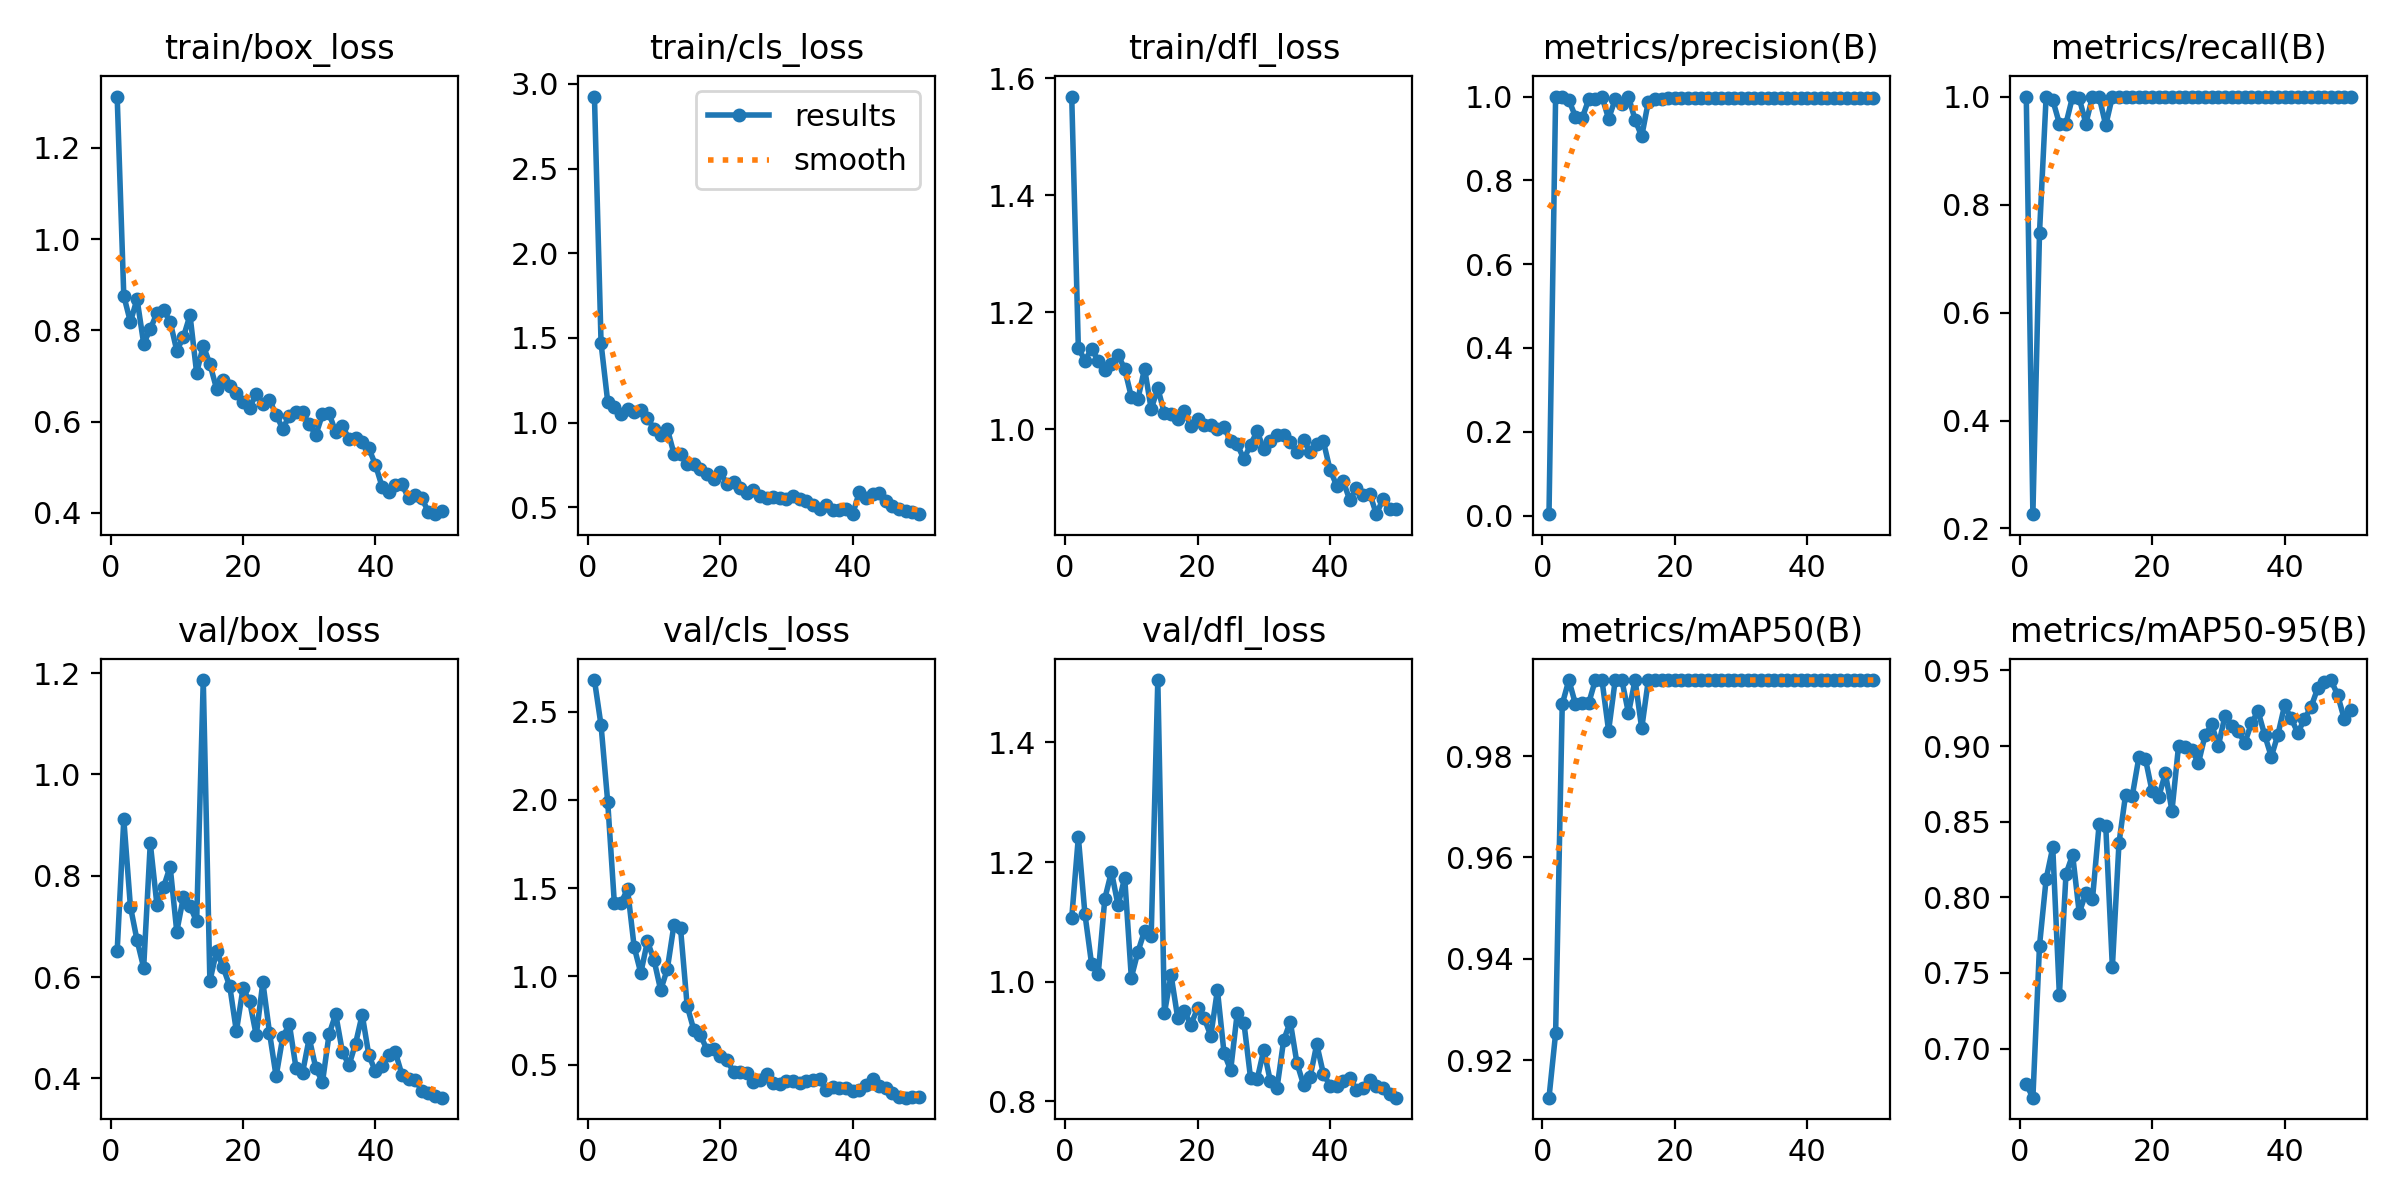

In [23]:
from IPython.display import Image
Image(filename='runs/detect/pupil_detector_v12/results.png')


In [25]:
!find runs -name "best.pt"


runs/detect/pupil_detector_v13/weights/best.pt
runs/detect/pupil_detector_v12/weights/best.pt


In [26]:
import os, glob, time
from ultralytics import YOLO
from IPython.display import display
from PIL import Image
import numpy as np

# 1) Pick the latest best.pt among your pupil_detector_* runs
candidates = glob.glob("runs/detect/pupil_detector_*/weights/best.pt")
assert candidates, "No best.pt found under runs/detect/*/weights/"
latest = max(candidates, key=os.path.getmtime)
print("Using weights:", latest)

# 2) Load model
model = YOLO(latest)

# 3) Inference on a folder (change path if needed)
source_dir = "/content/dataset/valid/images"
pred = model.predict(
    source=source_dir,
    imgsz=640,
    conf=0.25,
    iou=0.5,
    save=True,                 # saves annotated images
    project="runs/predict",    # output root
    name="pupil_eval",         # subfolder name
    stream=False,
    verbose=False
)

# 4) Display a few annotated results inline
#    Each `r` has .plot() -> numpy array with boxes drawn
shown = 0
for r in pred:
    if shown >= 5:
        break
    arr = r.plot()  # HWC, BGR np.array
    img = Image.fromarray(arr[..., ::-1])  # BGR -> RGB
    display(img)
    shown += 1

print("Saved annotated images to:", os.path.join("runs/predict", "pupil_eval"))


Output hidden; open in https://colab.research.google.com to view.

In [27]:
# Load the trained model
model = YOLO("runs/detect/pupil_detector_v13/weights/best.pt")

# Predict on an image
results = model("/content/dataset/valid/images/")

# Show image with bounding boxes
# Show the first few predictions
for r in results[:5]:
    r.show()

Output hidden; open in https://colab.research.google.com to view.

In [28]:
# Step 2: Define paths (edit these if needed)
zip_path = "/content/drive/MyDrive/dataset_V6.zip"  # <-- change this if your file is in a folder
extract_dir = "/content/dataset_V6"

# Step 3: Unzip the dataset
import zipfile

os.makedirs(extract_dir, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print(f"✅ Extracted dataset to: {extract_dir}")




# Step 4 (Optional): Copy the CSV if it's also on Drive
# If your CSV is in MyDrive, adjust the path accordingly

csv_drive_path = "/content/drive/MyDrive/dataset_V6.csv"
csv_colab_path = "/content/dataset_V6.csv"

!cp "{csv_drive_path}" "{csv_colab_path}"

print(f"✅ CSV copied to: {csv_colab_path}")




✅ Extracted dataset to: /content/dataset_V6
✅ CSV copied to: /content/dataset_V6.csv


In [30]:
from PIL import Image
import torch
from ultralytics import YOLO
import os

# Load YOLO model
model = YOLO("runs/detect/pupil_detector_v13/weights/best.pt")

# Paths
input_dir = "/content/dataset_V6/dataset_V6"
output_dir = "/content/dataset_V6/cropped"
os.makedirs(output_dir, exist_ok=True)

# Predict and crop
for img_file in os.listdir(input_dir):
    img_path = os.path.join(input_dir, img_file)
    results = model(img_path)
    boxes = results[0].boxes.xyxy.cpu().numpy()

    if len(boxes) == 0:
        continue  # Skip images with no detection

    # Crop first box
    x1, y1, x2, y2 = boxes[0].astype(int)
    image = Image.open(img_path)
    crop = image.crop((x1, y1, x2, y2))
    crop.save(os.path.join(output_dir, img_file))


Streaming output truncated to the last 5000 lines.
image 1/1 /content/dataset_V6/dataset_V6/RE_0559_S1_0559_frame538_Sec269.00.jpg: 448x640 1 Cornea, 7.9ms
Speed: 2.1ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 /content/dataset_V6/dataset_V6/RE_0518_S1_0518_frame707_Sec353.50.jpg: 448x640 1 Cornea, 7.7ms
Speed: 2.2ms preprocess, 7.7ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 /content/dataset_V6/dataset_V6/PH_0135_S1_2221_sec_0240_frame01.jpg: 448x640 1 Cornea, 7.7ms
Speed: 2.2ms preprocess, 7.7ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 /content/dataset_V6/dataset_V6/RE_0526_S1_0526_frame372_Sec186.00.jpg: 448x640 1 Cornea, 7.6ms
Speed: 2.2ms preprocess, 7.6ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 /content/dataset_V6/dataset_V6/RE_0566_S1_0566_frame23_Sec11.50.jpg: 448x640 1 Cornea, 7.6ms
Speed: 2.2ms preprocess, 7.6ms inference

In [33]:
import shutil

shutil.make_archive("/content/cropped_dataset", 'zip', "/content/dataset_V6/cropped")
from google.colab import files
files.download("/content/cropped_dataset.zip")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [31]:
class PadToSquareWithMean:
    def __call__(self, image):
        w, h = image.size
        max_dim = max(w, h)
        pad_left = (max_dim - w) // 2
        pad_top = (max_dim - h) // 2
        pad_right = max_dim - w - pad_left
        pad_bottom = max_dim - h - pad_top

        # Compute true mean color
        np_img = np.array(image)
        mean_color = tuple(np_img.reshape(-1, 3).mean(axis=0).astype(np.uint8))

        return TF.pad(image, (pad_left, pad_top, pad_right, pad_bottom),
                      fill=mean_color, padding_mode='constant')


In [ ]:
# ========== Config ==========
CSV_PATH = "dataset_V4.csv"
IMAGE_DIR = "/content/dataset_V4/cropped"
BATCH_SIZE = 64

# ========== Dataset ==========
class CataractDataset(Dataset):
    def __init__(self, dataframe, image_dir, transform=None):
        self.data = dataframe.reset_index(drop=True)
        self.image_dir = image_dir
        self.transform = transform
        self.label_map = {"low": 0, "moderate": 1, "high": 2, "mature": 3, "poor dilation": 4}

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        img_path = os.path.join(self.image_dir, row["filename"] + ".jpg")
        try:
            image = Image.open(img_path).convert("RGB")
        except FileNotFoundError:
            print(f"Missing image: {img_path}")
            return self.__getitem__((idx + 1) % len(self.data))

        label = self.label_map[row["label"].lower()]
        if self.transform:
            image = self.transform(image)
        return image, torch.tensor(label)

# ========== Load and Prepare CSV ==========
df = pd.read_csv(CSV_PATH)
df.columns = df.columns.str.strip()
df.rename(columns={"Frame Name": "filename"}, inplace=True)

# Derive label column from binary indicators
df["label"] = None
df.loc[df["Low Nuclear Density"] == 1.0, "label"] = "low"
df.loc[df["Moderate Nuclear Density"] == 1.0, "label"] = "moderate"
df.loc[df["High Nuclear Density"] == 1.0, "label"] = "high"
df.loc[df["Mature"] == 1.0, "label"] = "mature"
df.loc[df["Poor Dilation"] == 1.0, "label"] = "poor dilation"


# Keep only valid rows
df = df[df["label"].notna()]
df = df[["filename", "label"]]

# ========== Train / Val / Test Split ==========
train_val_df, test_df = train_test_split(df, test_size=0.2, stratify=df["label"], random_state=42)
train_df, val_df = train_test_split(train_val_df, test_size=0.2, stratify=train_val_df["label"], random_state=42)

# Map labels to integer indices
label_map = {"low": 0, "moderate": 1, "high": 2, "mature": 3, "poor dilation": 4}
train_df["class_idx"] = train_df["label"].map(label_map)

# Compute class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_df["class_idx"]),
    y=train_df["class_idx"]
)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float)

# ========== Transforms ==========
transform = transforms.Compose([
    PadToSquareWithMean(),  # <-- add this at the top
    transforms.Resize((260, 260)),  # match model input size
    transforms.RandomRotation(degrees=15),
    transforms.RandomAffine(degrees=10, translate=(0.05, 0.05), scale=(0.95, 1.05)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
    transforms.RandomErasing(p=0.3)
])
val_test_transform = transforms.Compose([
    PadToSquareWithMean(),
    transforms.Resize((260, 260)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


# ========== Datasets and Dataloaders ==========
train_dataset = CataractDataset(train_df, IMAGE_DIR, transform)
# val_dataset = CataractDataset(val_df, IMAGE_DIR, transform)
# test_dataset = CataractDataset(test_df, IMAGE_DIR, transform)
val_dataset = CataractDataset(val_df, IMAGE_DIR, val_test_transform)
test_dataset = CataractDataset(test_df, IMAGE_DIR, val_test_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# ========== Return Utility ==========
def get_dataloaders():
    return train_loader, val_loader, test_loader, class_weights_tensor, df


In [ ]:
import torch.nn as nn
from torchvision import models

def efficientnet_b2(weights="DEFAULT", fine_tune=True):
    """
    EfficientNet-B2 adapted to 5 classes.

    Parameters
    ----------
    weights : str | torchvision.models.EfficientNet_B2_Weights | None
        "DEFAULT"  → ImageNet-1K weights (torchvision ≥0.15).
        None       → random initialization.
        Or pass an explicit EfficientNet_B2_Weights enum.
    fine_tune : bool
        True  → freeze everything except last two MBConv blocks + classifier.
        False → leave all layers trainable.

    Returns
    -------
    model : nn.Module
    """

    # 1) Load backbone
    eff_weights = (
        models.EfficientNet_B2_Weights.DEFAULT if weights == "DEFAULT" else weights
    )
    model = models.efficientnet_b2(weights=eff_weights)

    # 2) Freeze / unfreeze
    if fine_tune:
        for p in model.parameters():
            p.requires_grad = False
        # Unfreeze the deepest layers (features.6 & features.7) and the classifier
        for name, p in model.named_parameters():
            if name.startswith(("features.6", "features.7", "classifier")):
                p.requires_grad = True

    # 3) Replace classifier head (EffNet-B2 head = Sequential[Dropout, Linear])
    in_feats = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(in_feats, 5)   # 5 classes

    return model


Using device: cuda
Total number of samples: 1888

Class distribution:
label
mature           522
low              460
moderate         366
high             341
poor dilation    199
Name: count, dtype: int64


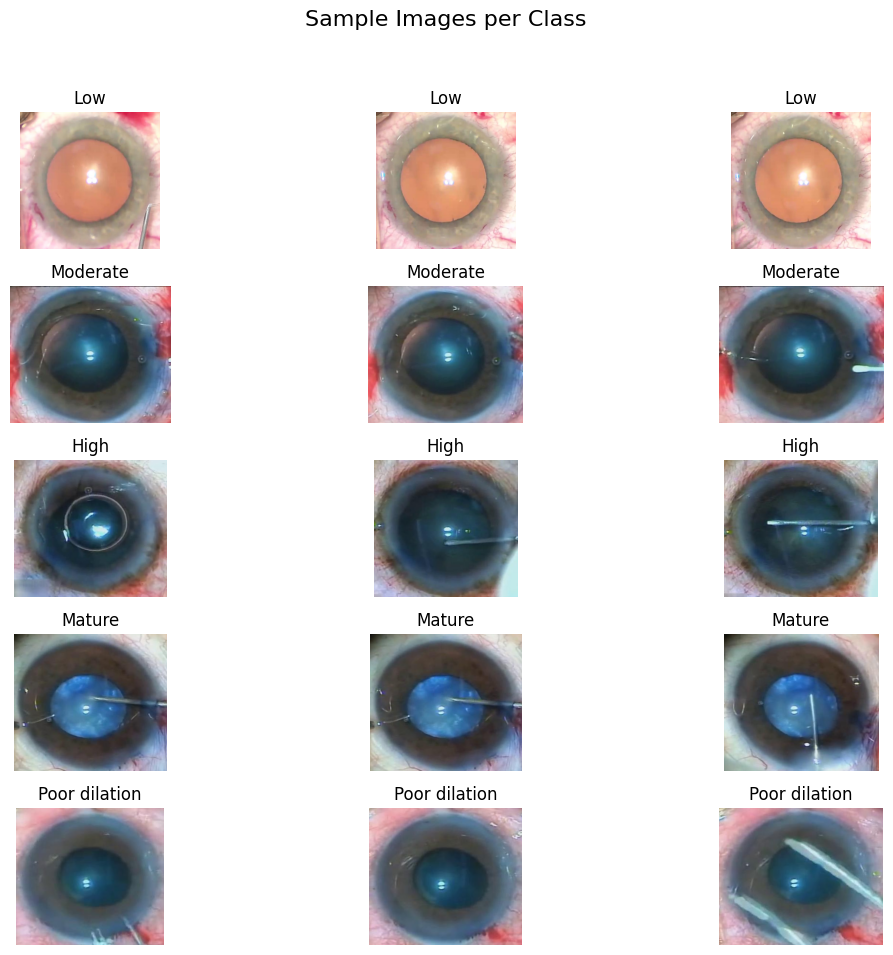

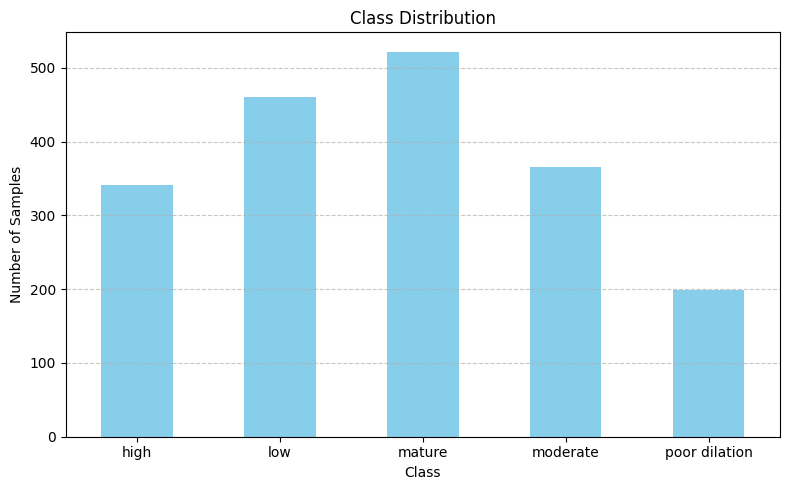

Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-c35c1473.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-c35c1473.pth
100%|██████████| 35.2M/35.2M [00:00<00:00, 214MB/s]


Model is on device: cuda:0
Epoch: [1/60] | Step: [1/19] | Loss: 1.662037
Epoch: [1/60] | Step: [3/19] | Loss: 1.617046
Epoch: [1/60] | Step: [5/19] | Loss: 1.615764
Epoch: [1/60] | Step: [7/19] | Loss: 1.595843
Epoch: [1/60] | Step: [9/19] | Loss: 1.541162
Missing image: /content/dataset_V4/cropped/RE_1783_S1_1783__sec0075__frame3.jpg
Epoch: [1/60] | Step: [11/19] | Loss: 1.535347
Epoch: [1/60] | Step: [13/19] | Loss: 1.518421
Epoch: [1/60] | Step: [15/19] | Loss: 1.540591
Epoch: [1/60] | Step: [17/19] | Loss: 1.484074
Epoch: [1/60] | Step: [19/19] | Loss: 1.536617
Epoch: [1/60] | Loss: 1.536617
Valid Loss: 1.459968 | Acc: 0.4404
Epoch: [2/60] | Step: [1/19] | Loss: 1.431204
Epoch: [2/60] | Step: [3/19] | Loss: 1.522870
Epoch: [2/60] | Step: [5/19] | Loss: 1.549134
Epoch: [2/60] | Step: [7/19] | Loss: 1.433250
Missing image: /content/dataset_V4/cropped/RE_1783_S1_1783__sec0075__frame3.jpg
Epoch: [2/60] | Step: [9/19] | Loss: 1.473791
Epoch: [2/60] | Step: [11/19] | Loss: 1.391189
Epoch

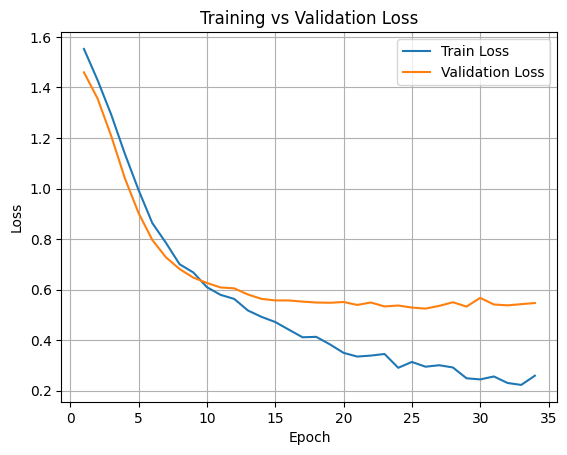

               precision    recall  f1-score   support

          low     0.8763    0.9239    0.8995        92
     moderate     0.7925    0.5753    0.6667        73
         high     0.6296    0.7500    0.6846        68
       mature     0.8252    0.8095    0.8173       105
poor dilation     0.8182    0.9000    0.8571        40

     accuracy                         0.7910       378
    macro avg     0.7884    0.7918    0.7850       378
 weighted avg     0.7954    0.7910    0.7885       378


Overall Accuracy: 0.7910
Macro F1-score  : 0.7850
Weighted F1-score: 0.7885


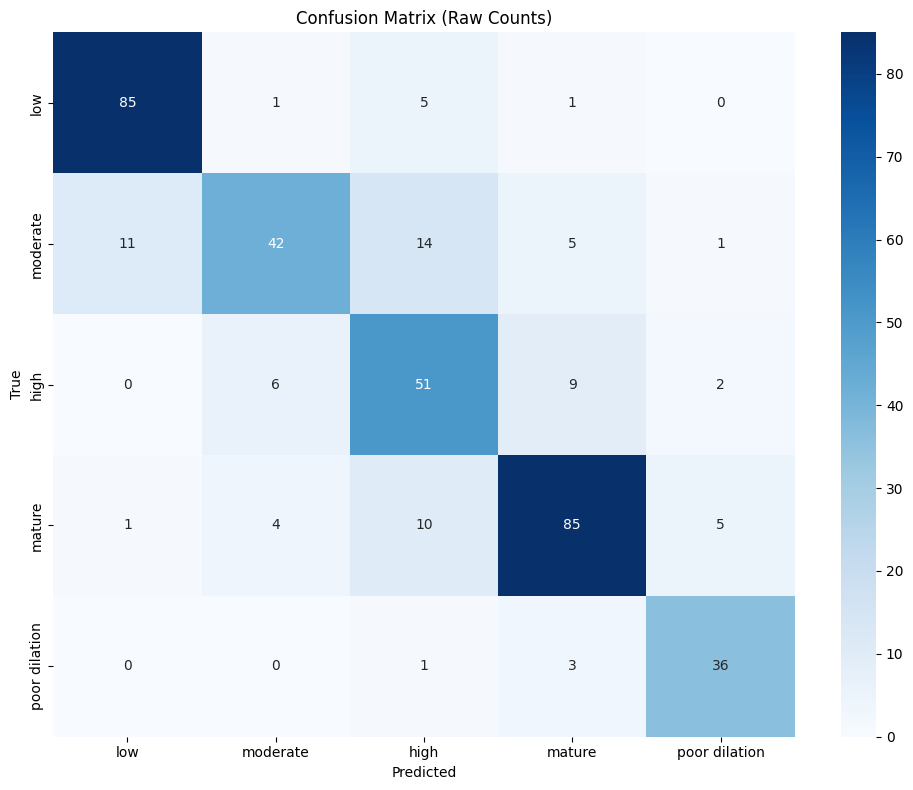

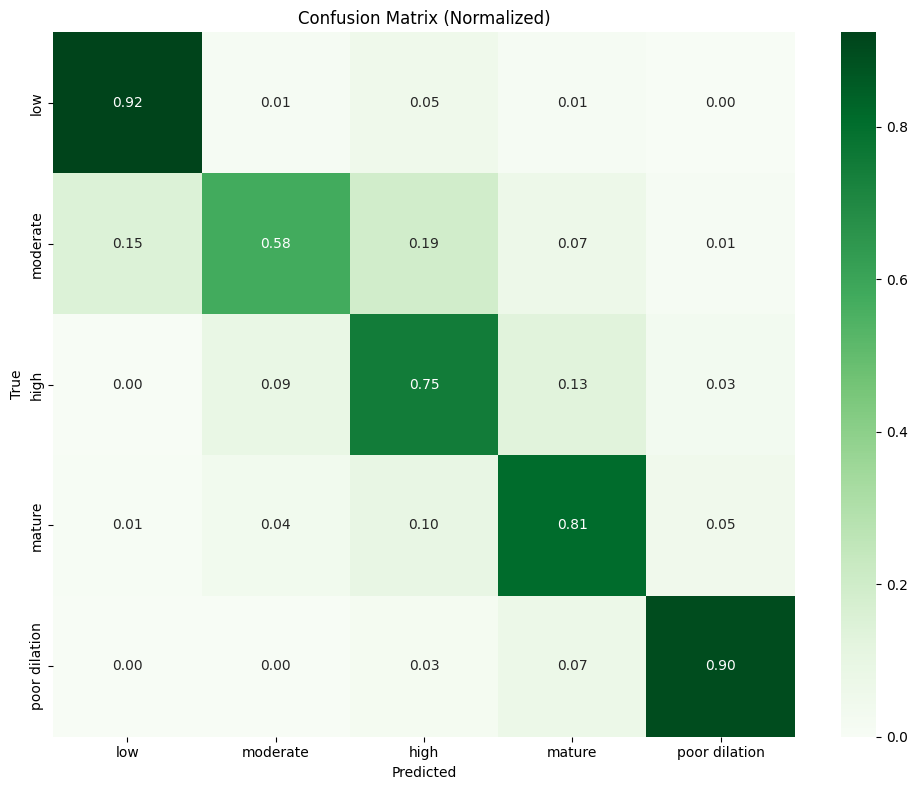

In [ ]:
CSV_PATH = "/content/dataset_V4.csv"
IMAGE_DIR = "/content/dataset_V4/cropped"

train_loader, val_loader, test_loader, class_weights_tensor, df = get_dataloaders()


# Params
num_epochs = 60
lr = 1e-3
patience = 8
min_delta = 1e-4
best_val_loss = float('inf')
epochs_no_improve = 0

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")



# Print dataset statistics
print(f"Total number of samples: {len(df)}")
print("\nClass distribution:")
print(df['label'].value_counts())

# Define the class labels (ordered)
classes = ["low", "moderate", "high", "mature", "poor dilation"]

# Create a subplot grid: 4 rows (classes) x 3 columns (images)
fig, axs = plt.subplots(len(classes), 3, figsize=(12, 10))
fig.suptitle("Sample Images per Class", fontsize=16)

# Loop over each class
for i, cls in enumerate(classes):
    class_samples = df[df["label"] == cls].head(3)
    for j, (_, row) in enumerate(class_samples.iterrows()):
        img_path = os.path.join(IMAGE_DIR, row["filename"] + ".jpg")
        try:
            image = Image.open(img_path)
            axs[i, j].imshow(image)
            axs[i, j].axis("off")
            axs[i, j].set_title(f"{cls.capitalize()}")
        except FileNotFoundError:
            axs[i, j].axis("off")
            axs[i, j].set_title("Image not found")

plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # adjust for suptitle
plt.show()

# Plot bar chart of class distribution
plt.figure(figsize=(8, 5))
df["label"].value_counts().sort_index().plot(kind='bar', color='skyblue')
plt.title("Class Distribution")
plt.xlabel("Class")
plt.ylabel("Number of Samples")
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()




# Training
# model = resnet18(fine_tune=False).to(device)  # change to True if you want to fine-tune deeper layers
model = efficientnet_b2(fine_tune=True).to(device)
# Loss Function
# class_weights_tensor = class_weights_tensor.to(device)  # move to GPU
loss_fn = torch.nn.CrossEntropyLoss()

# Optimizer
# optimizer = torch.optim.Adam(model.fc.parameters(), lr=lr)
# optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-2)

optimizer = torch.optim.AdamW([
    {"params": model.features.parameters(), "lr": 3e-5},   # very small LR for backbone
    {"params": model.classifier.parameters(), "lr": 3e-4}  # higher LR for classifier
], weight_decay=1e-2)

# Scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)


train_loss = []
valid_loss = []

print(f"Model is on device: {next(model.parameters()).device}")

# Train Loop
num_steps = len(train_loader)
for epochs in range(num_epochs):
    model.train()
    running_loss = 0.0
    for j, (imgs, lbls) in enumerate(train_loader):
        imgs, lbls = imgs.to(device), lbls.to(device)
        optimizer.zero_grad()
        out = model(imgs)
        loss = loss_fn(out, lbls)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if j % 2 == 0:
            print('Epoch: [{}/{}] | Step: [{}/{}] | Loss: {:.6f}'
                  .format(epochs+1, num_epochs, j+1, num_steps, loss.item()))
    train_loss.append(running_loss / num_steps)
    print('Epoch: [{}/{}] | Loss: {:.6f}'
          .format(epochs+1, num_epochs, loss.item()))

#---------------------
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        running_valid_loss = 0.0
        for imgs, lbls in val_loader:
            imgs, lbls = imgs.to(device), lbls.to(device)
            out = model(imgs)
            loss_val = loss_fn(out, lbls)
            running_valid_loss += loss_val.item()
            predicted = torch.argmax(out, dim=1)
            correct += (predicted == lbls).sum().item()
            total += lbls.size(0)
        avg_val_loss = running_valid_loss / len(val_loader)
        valid_loss.append(avg_val_loss)
        print('Valid Loss: {:.6f} | Acc: {:.4f}'.format(valid_loss[-1], correct / total))

        # Step the scheduler
        scheduler.step(avg_val_loss)


        # Early stopping
        if best_val_loss - avg_val_loss > min_delta:
            best_val_loss = avg_val_loss
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print("Early stopping triggered.")
                break

# Plot losses
plt.plot(range(1, len(train_loss)+1), train_loss, label='Train Loss')
plt.plot(range(1, len(valid_loss)+1), valid_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.show()




# # Predictions and true labels
# all_preds = []
# all_labels = []
#
# model.eval()
# with torch.no_grad():
#     for imgs, lbls in test_loader:
#         imgs = imgs.to(device)
#         outputs = model(imgs)
#         preds = torch.argmax(outputs, dim=1).cpu()
#         all_preds.extend(preds.numpy())
#         all_labels.extend(lbls.numpy())
#
# # Classification Report
# print(classification_report(all_labels, all_preds, target_names=classes))
#
# # Confusion Matrix
# cm = confusion_matrix(all_labels, all_preds)
# plt.figure(figsize=(10, 8))
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
# plt.xlabel('Predicted')
# plt.ylabel('True')
# plt.title('Confusion Matrix')
# plt.show()
#


# Evaluation
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for imgs, lbls in test_loader:
        imgs, lbls = imgs.to(device), lbls.to(device)
        outputs = model(imgs)
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(lbls.cpu().numpy())

# Convert to numpy arrays
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# Print classification report
report = classification_report(all_labels, all_preds, target_names=classes, digits=4)
print(report)

# Save report as a dataframe (optional)
report_df = pd.DataFrame(classification_report(all_labels, all_preds, target_names=classes, output_dict=True)).T
report_df.to_csv("classification_report.csv")

# Accuracy and F1 scores
print(f"\nOverall Accuracy: {accuracy_score(all_labels, all_preds):.4f}")
print(f"Macro F1-score  : {f1_score(all_labels, all_preds, average='macro'):.4f}")
print(f"Weighted F1-score: {f1_score(all_labels, all_preds, average='weighted'):.4f}")

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot raw confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Raw Counts)')
plt.tight_layout()
plt.show()

# Plot normalized confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Greens', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Normalized)')
plt.tight_layout()
plt.show()



torch.save(model.state_dict(), "efficientnet_b2_cataract.pth")


In [ ]:
CSV_PATH = "dataset_V4.csv"
IMAGE_DIR = "/content/dataset_V4/dataset_V4"

# ===== Base + Augmentation Transforms =====
base_transform = transforms.Compose([
    PadToSquareWithMean(),
    transforms.Resize((260, 260)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])  # standard ImageNet normalization
])

aug_transform = transforms.Compose([
    PadToSquareWithMean(),
    transforms.Resize((260, 260)),
    transforms.RandomRotation(25),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3),
    transforms.RandomAffine(15, translate=(0.1,0.1)),
    # transforms.RandomResizedCrop(224, scale=(0.7, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# ========== Dataset ==========
class CataractDataset(Dataset):
    def __init__(self, dataframe, image_dir, transform=None):
        self.data = dataframe.reset_index(drop=True)
        self.image_dir = image_dir
        self.transform = transform
        self.label_map = {"low": 0, "moderate": 1, "high": 2, "mature": 3, "poor dilation": 4}

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        img_path = os.path.join(self.image_dir, row["filename"] + ".jpg")
        try:
            image = Image.open(img_path).convert("RGB")
        except FileNotFoundError:
            print(f"Missing image: {img_path}")
            return self.__getitem__((idx + 1) % len(self.data))

        label = self.label_map[row["label"].lower()]
        if self.transform:
            image = self.transform(image)
        return image, torch.tensor(label)

# ========== Load and Prepare CSV ==========
df = pd.read_csv(CSV_PATH)
df.columns = df.columns.str.strip()
df.rename(columns={"Frame Name": "filename"}, inplace=True)

# Derive label column from binary indicators
df["label"] = None
df.loc[df["Low Nuclear Density"] == 1.0, "label"] = "low"
df.loc[df["Moderate Nuclear Density"] == 1.0, "label"] = "moderate"
df.loc[df["High Nuclear Density"] == 1.0, "label"] = "high"
df.loc[df["Mature"] == 1.0, "label"] = "mature"
df.loc[df["Poor Dilation"] == 1.0, "label"] = "poor dilation"


# Keep only valid rows
df = df[df["label"].notna()]
df = df[["filename", "label"]]


In [ ]:
def efficientnet_b2(num_classes=5, pretrained=True, phase="warmup"):
    """
    EfficientNet-B2 with progressive fine-tuning.

    Parameters
    ----------
    num_classes : int
        Number of output classes.
    pretrained : bool
        Whether to load ImageNet pretrained weights.
    phase : str
        "warmup"   → train only classifier
        "partial"  → unfreeze last 2 feature blocks + classifier
        "full"     → train all layers

    Returns
    -------
    model : nn.Module
    """
    weights = models.EfficientNet_B2_Weights.DEFAULT if pretrained else None
    model = models.efficientnet_b2(weights=weights)

    # Replace final classifier
    in_feats = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(in_feats, num_classes)

    # Set requires_grad depending on phase
    for name, param in model.named_parameters():
        param.requires_grad = False  # freeze everything first

        if phase == "warmup" and name.startswith("classifier"):
            param.requires_grad = True

        elif phase == "partial" and name.startswith(("features.6", "features.7", "classifier")):
            param.requires_grad = True

        elif phase == "full":
            param.requires_grad = True

    return model


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # ===== EfficientNet with Progressive Phases =====
# def efficientnet_b2(num_classes=5, pretrained=True, phase="warmup"):
#     weights = models.EfficientNet_B2_Weights.DEFAULT if pretrained else None
#     model = models.efficientnet_b2(weights=weights)

#     # Replace classifier
#     in_feats = model.classifier[1].in_features
#     model.classifier[1] = nn.Linear(in_feats, num_classes)

#     # Freeze/unfreeze according to phase
#     for name, param in model.named_parameters():
#         param.requires_grad = False

#         if phase == "warmup" and name.startswith("classifier"):
#             param.requires_grad = True
#         elif phase == "partial" and name.startswith(("features.6", "features.7", "classifier")):
#             param.requires_grad = True
#         elif phase == "full":
#             param.requires_grad = True

#     return model

# ===== Training Utilities =====
def train_one_epoch(model, loader, optimizer, criterion, epoch, total_epochs, phase_name):
    model.train()
    running_loss, preds_all, labels_all = 0.0, [], []
    total_steps = len(loader)

    for step, (images, labels) in enumerate(loader, 1):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        preds_all.extend(outputs.argmax(1).cpu().numpy())
        labels_all.extend(labels.cpu().numpy())

        # Print per-step loss
        if (step+1) % 5 == 0:
          print(f"[{phase_name} | Epoch {epoch}/{total_epochs} | Step {step}/{total_steps}] "
              f"Step Loss: {loss.item():.4f}")


    acc = accuracy_score(labels_all, preds_all)
    f1 = f1_score(labels_all, preds_all, average="weighted")
    return running_loss / len(loader.dataset), acc, f1, labels_all, preds_all


def evaluate(model, loader, criterion):
    model.eval()
    running_loss, preds_all, labels_all, probs_all = 0.0, [], [], []

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            preds_all.extend(outputs.argmax(1).cpu().numpy())
            labels_all.extend(labels.cpu().numpy())
            probs_all.extend(F.softmax(outputs, dim=1).cpu().numpy())

    acc = accuracy_score(labels_all, preds_all)
    f1 = f1_score(labels_all, preds_all, average="weighted")
    return running_loss / len(loader.dataset), acc, f1, labels_all, preds_all, probs_all


def progressive_training(train_loader, val_loader, num_classes=5):
    phases = [
        {"name": "warmup", "epochs": 10, "lr": 1e-3},
        {"name": "partial", "epochs": 15, "lr": 5e-4},
        {"name": "full", "epochs": 20, "lr": 1e-5},
    ]

    criterion = nn.CrossEntropyLoss()
    prev_phase = None

    all_train_losses = []
    all_val_losses = []

    for phase in phases:
        print(f"\n=== Phase: {phase['name']} ===")

        if prev_phase is None:
            model = efficientnet_b2(num_classes=num_classes, phase="warmup").to(device)
            # model = efficientnet_b3(num_classes=num_classes, phase="warmup").to(device)
            # model = EfficientNetB2WithDropout(num_classes=num_classes, phase="warmup").to(device)

        else:
            model = efficientnet_b2(num_classes=num_classes, phase=phase["name"]).to(device)
            model.load_state_dict(torch.load(f"best_model_{prev_phase}.pth"))
            # model = efficientnet_b3(num_classes=num_classes, phase=phase["name"]).to(device)
            # model.load_state_dict(torch.load(f"best_model_{prev_phase}.pth"))
        #     model = EfficientNetB2WithDropout(num_classes=num_classes, phase=phase["name"]).to(device)
        #     model.load_state_dict(torch.load(f"best_model_{prev_phase}.pth"))
        # # optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()),
        #                        lr=phase["lr"], weight_decay=1e-4)

        optimizer = optim.AdamW(
        filter(lambda p: p.requires_grad, model.parameters()),
        lr=phase["lr"],              # keep the LR from your phase config
        weight_decay=1e-4            # same weight decay you used before
        )

        scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True)
        # # T_max is the number of epochs over which to anneal from initial lr → eta_min
        # scheduler = CosineAnnealingLR(
        #     optimizer,
        #     T_max=phase["epochs"],
        #     eta_min=1e-6,    # floor learning rate
        #     last_epoch=-1    # start from scratch each phase
        # )

        best_val_loss = np.inf
        patience, patience_counter = 3, 0

        for epoch in range(1, phase["epochs"] + 1):
            train_loss, train_acc, train_f1, y_train, y_pred_train = train_one_epoch(
                model, train_loader, optimizer, criterion, epoch, phase["epochs"], phase["name"])
            val_loss, val_acc, val_f1, y_val, y_pred_val, y_proba_val = evaluate(
                model, val_loader, criterion)

            # update LR scheduler
            if isinstance(scheduler, ReduceLROnPlateau):
                scheduler.step(val_loss)
            else:
                scheduler.step()

            # scheduler.step()

            all_train_losses.append(train_loss)
            all_val_losses.append(val_loss)

            # End of epoch summary
            print(f"Epoch [{epoch}/{phase['epochs']}], "
                  f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f}, F1: {train_f1:.4f} | "
                  f"Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}, F1: {val_f1:.4f}")

            # Early stopping
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                patience_counter = 0
                torch.save(model.state_dict(), f"best_model_{phase['name']}.pth")
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print("Early stopping triggered.")
                    break

        # ---- After each phase: Per-class metrics ----
        print(f"\n=== Detailed Metrics for Phase: {phase['name']} ===")
        print(classification_report(y_val, y_pred_val, target_names=["low", "moderate", "high", "mature", "poor dilation"]))

        cm = confusion_matrix(y_val, y_pred_val)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                      display_labels=["low", "moderate", "high", "mature", "poor dilation"])
        disp.plot(cmap="Blues")
        plt.show()

        # ROC-AUC (One-vs-Rest)
        try:
            roc_auc = roc_auc_score(y_val, y_proba_val, multi_class="ovr")
            print(f"ROC-AUC: {roc_auc:.4f}")
        except ValueError:
            print("ROC-AUC could not be computed (need probabilities for all classes).")

        prev_phase = phase["name"]


    plt.figure(figsize=(8,6))
    plt.plot(all_train_losses, label="Train Loss")
    plt.plot(all_val_losses, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training vs Validation Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

    print("\nTraining complete. Best models for each phase saved.")
    return model



=== Phase: warmup ===


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


[warmup | Epoch 1/10 | Step 4/19] Step Loss: 1.4782
Missing image: /content/dataset_V4/cropped/RE_1783_S1_1783__sec0075__frame3.jpg
[warmup | Epoch 1/10 | Step 9/19] Step Loss: 1.5169
[warmup | Epoch 1/10 | Step 14/19] Step Loss: 1.5261
[warmup | Epoch 1/10 | Step 19/19] Step Loss: 1.4857
Epoch [1/10], Train Loss: 1.5149, Acc: 0.3369, F1: 0.2757 | Val Loss: 1.4004, Acc: 0.4536, F1: 0.3795
[warmup | Epoch 2/10 | Step 4/19] Step Loss: 1.3297
Missing image: /content/dataset_V4/cropped/RE_1783_S1_1783__sec0075__frame3.jpg
[warmup | Epoch 2/10 | Step 9/19] Step Loss: 1.3535
[warmup | Epoch 2/10 | Step 14/19] Step Loss: 1.2981
[warmup | Epoch 2/10 | Step 19/19] Step Loss: 1.2845
Epoch [2/10], Train Loss: 1.3241, Acc: 0.5199, F1: 0.4945 | Val Loss: 1.2825, Acc: 0.5166, F1: 0.4516
[warmup | Epoch 3/10 | Step 4/19] Step Loss: 1.1695
Missing image: /content/dataset_V4/cropped/RE_1783_S1_1783__sec0075__frame3.jpg
[warmup | Epoch 3/10 | Step 9/19] Step Loss: 1.2300
[warmup | Epoch 3/10 | Step 14/1

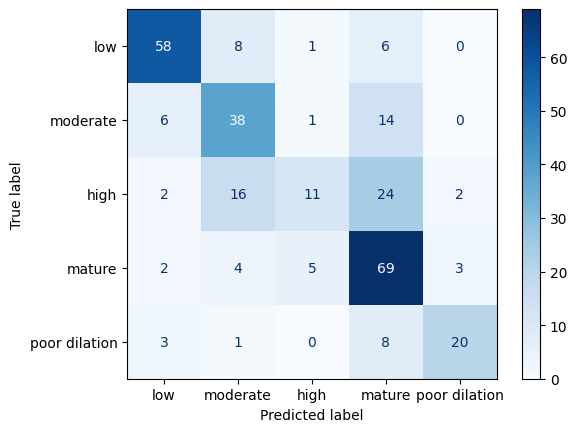

ROC-AUC: 0.8971

=== Phase: partial ===


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Missing image: /content/dataset_V4/cropped/RE_1783_S1_1783__sec0075__frame3.jpg
[partial | Epoch 1/15 | Step 4/19] Step Loss: 0.8156
[partial | Epoch 1/15 | Step 9/19] Step Loss: 0.7560
[partial | Epoch 1/15 | Step 14/19] Step Loss: 0.7283
[partial | Epoch 1/15 | Step 19/19] Step Loss: 0.6316
Epoch [1/15], Train Loss: 0.7642, Acc: 0.7136, F1: 0.7096 | Val Loss: 0.6283, Acc: 0.7384, F1: 0.7432
Missing image: /content/dataset_V4/cropped/RE_1783_S1_1783__sec0075__frame3.jpg
[partial | Epoch 2/15 | Step 4/19] Step Loss: 0.3875
[partial | Epoch 2/15 | Step 9/19] Step Loss: 0.4512
[partial | Epoch 2/15 | Step 14/19] Step Loss: 0.5453
[partial | Epoch 2/15 | Step 19/19] Step Loss: 0.5052
Epoch [2/15], Train Loss: 0.4934, Acc: 0.8146, F1: 0.8165 | Val Loss: 0.6839, Acc: 0.7682, F1: 0.7581
Missing image: /content/dataset_V4/cropped/RE_1783_S1_1783__sec0075__frame3.jpg
[partial | Epoch 3/15 | Step 4/19] Step Loss: 0.2586
[partial | Epoch 3/15 | Step 9/19] Step Loss: 0.4019
[partial | Epoch 3/15 

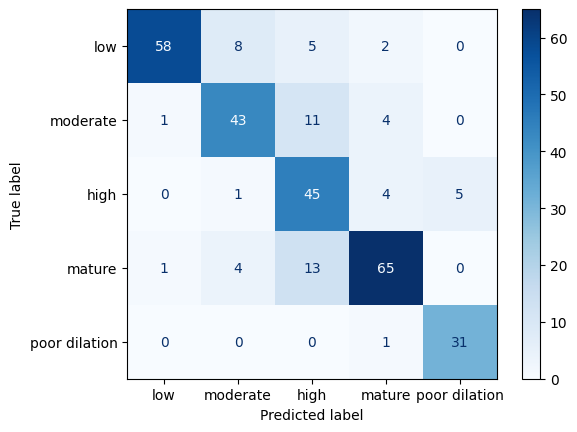

ROC-AUC: 0.9610

=== Phase: full ===


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


[full | Epoch 1/20 | Step 4/19] Step Loss: 0.1397
[full | Epoch 1/20 | Step 9/19] Step Loss: 0.2986
Missing image: /content/dataset_V4/cropped/RE_1783_S1_1783__sec0075__frame3.jpg
[full | Epoch 1/20 | Step 14/19] Step Loss: 0.2290
[full | Epoch 1/20 | Step 19/19] Step Loss: 0.1895
Epoch [1/20], Train Loss: 0.2162, Acc: 0.9205, F1: 0.9202 | Val Loss: 0.4781, Acc: 0.8113, F1: 0.8088
[full | Epoch 2/20 | Step 4/19] Step Loss: 0.1794
[full | Epoch 2/20 | Step 9/19] Step Loss: 0.1926
Missing image: /content/dataset_V4/cropped/RE_1783_S1_1783__sec0075__frame3.jpg
[full | Epoch 2/20 | Step 14/19] Step Loss: 0.1961
[full | Epoch 2/20 | Step 19/19] Step Loss: 0.3265
Epoch [2/20], Train Loss: 0.1992, Acc: 0.9263, F1: 0.9260 | Val Loss: 0.4728, Acc: 0.8146, F1: 0.8125
[full | Epoch 3/20 | Step 4/19] Step Loss: 0.1066
[full | Epoch 3/20 | Step 9/19] Step Loss: 0.1759
Missing image: /content/dataset_V4/cropped/RE_1783_S1_1783__sec0075__frame3.jpg
[full | Epoch 3/20 | Step 14/19] Step Loss: 0.1620
[

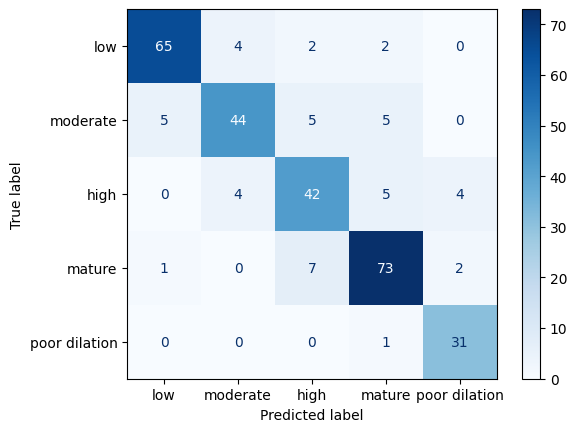

ROC-AUC: 0.9743


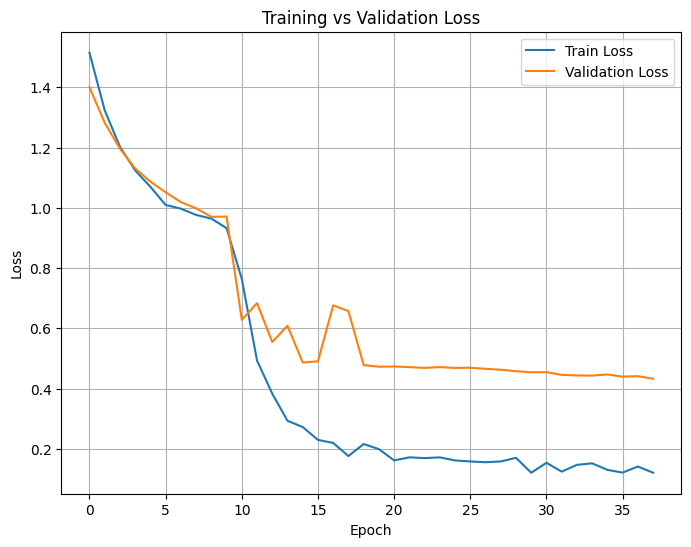


Training complete. Best models for each phase saved.


In [ ]:
model = progressive_training(train_loader, val_loader, num_classes=5)

In [ ]:
# ========= Balance Function =========
def balance_dataset(df, image_dir, target_per_class = df['label'].value_counts().max()):
    datasets = []
    class_counts = df['label'].value_counts().to_dict()
    augmented_summary = {}

    for label, count in class_counts.items():
        class_df = df[df['label'] == label]

        # Keep all original samples
        datasets.append(CataractDataset(class_df, image_dir, transform=base_transform))

        # Only add augmentation if class is below target
        if count < target_per_class:
            needed = target_per_class - count
            aug_rows = class_df.sample(needed, replace=True, random_state=42)
            datasets.append(CataractDataset(aug_rows, image_dir, transform=aug_transform))
            augmented_summary[label] = needed
        else:
            augmented_summary[label] = 0  # nothing added

    balanced_dataset = ConcatDataset(datasets)

    # Print summary
    print("\n=== Balancing Summary (No Downsampling) ===")
    for label, count in class_counts.items():
        added = augmented_summary[label]
        final_count = count + added
        print(f"{label:15s} | Original: {count:4d} | Added: {added:4d} | Final: {final_count:4d}")
    print(f"\nTotal balanced dataset size: {len(balanced_dataset)}")

    return balanced_dataset


df = pd.read_csv(CSV_PATH)
df.columns = df.columns.str.strip()
df.rename(columns={"Frame Name": "filename"}, inplace=True)

# Derive labels from binary indicators
df["label"] = None
df.loc[df["Low Nuclear Density"] == 1.0, "label"] = "low"
df.loc[df["Moderate Nuclear Density"] == 1.0, "label"] = "moderate"
df.loc[df["High Nuclear Density"] == 1.0, "label"] = "high"
df.loc[df["Mature"] == 1.0, "label"] = "mature"
df.loc[df["Poor Dilation"] == 1.0, "label"] = "poor dilation"

df = df[df["label"].notna()]
df = df[["filename", "label"]]

# ========= Split Dataset =========
train_df, temp_df = train_test_split(df, test_size=0.3, stratify=df['label'], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['label'], random_state=42)

print(f"Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}")

# ========= Create Datasets =========
train_dataset = balance_dataset(train_df, IMAGE_DIR, target_per_class=df['label'].value_counts().max())
val_dataset = CataractDataset(val_df, IMAGE_DIR, transform=base_transform)
test_dataset = CataractDataset(test_df, IMAGE_DIR, transform=base_transform)

# ========= Create DataLoaders =========
BATCH_SIZE = 64
num_cpu = multiprocessing.cpu_count()
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=num_cpu//2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=num_cpu//2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=num_cpu//2, pin_memory=True)



Train: 1321, Val: 283, Test: 284

=== Balancing Summary (No Downsampling) ===
mature          | Original:  365 | Added:  157 | Final:  522
low             | Original:  322 | Added:  200 | Final:  522
moderate        | Original:  256 | Added:  266 | Final:  522
high            | Original:  239 | Added:  283 | Final:  522
poor dilation   | Original:  139 | Added:  383 | Final:  522

Total balanced dataset size: 2610


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # ===== EfficientNet with Progressive Phases =====
# def efficientnet_b2(num_classes=5, pretrained=True, phase="warmup"):
#     weights = models.EfficientNet_B2_Weights.DEFAULT if pretrained else None
#     model = models.efficientnet_b2(weights=weights)

#     # Replace classifier
#     in_feats = model.classifier[1].in_features
#     model.classifier[1] = nn.Linear(in_feats, num_classes)

#     # Freeze/unfreeze according to phase
#     for name, param in model.named_parameters():
#         param.requires_grad = False

#         if phase == "warmup" and name.startswith("classifier"):
#             param.requires_grad = True
#         elif phase == "partial" and name.startswith(("features.6", "features.7", "classifier")):
#             param.requires_grad = True
#         elif phase == "full":
#             param.requires_grad = True

#     return model

# ===== Training Utilities =====
def train_one_epoch(model, loader, optimizer, criterion, epoch, total_epochs, phase_name):
    model.train()
    running_loss, preds_all, labels_all = 0.0, [], []
    total_steps = len(loader)

    for step, (images, labels) in enumerate(loader, 1):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        preds_all.extend(outputs.argmax(1).cpu().numpy())
        labels_all.extend(labels.cpu().numpy())

        # Print per-step loss
        if (step+1) % 5 == 0:
          print(f"[{phase_name} | Epoch {epoch}/{total_epochs} | Step {step}/{total_steps}] "
              f"Step Loss: {loss.item():.4f}")


    acc = accuracy_score(labels_all, preds_all)
    f1 = f1_score(labels_all, preds_all, average="weighted")
    return running_loss / len(loader.dataset), acc, f1, labels_all, preds_all


def evaluate(model, loader, criterion):
    model.eval()
    running_loss, preds_all, labels_all, probs_all = 0.0, [], [], []

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            preds_all.extend(outputs.argmax(1).cpu().numpy())
            labels_all.extend(labels.cpu().numpy())
            probs_all.extend(F.softmax(outputs, dim=1).cpu().numpy())

    acc = accuracy_score(labels_all, preds_all)
    f1 = f1_score(labels_all, preds_all, average="weighted")
    return running_loss / len(loader.dataset), acc, f1, labels_all, preds_all, probs_all


def progressive_training(train_loader, val_loader, num_classes=5):
    phases = [
        {"name": "warmup", "epochs": 15, "lr": 1e-3},
        {"name": "partial", "epochs": 15, "lr": 1e-4},
        {"name": "full", "epochs": 20, "lr": 1e-5},
    ]

    criterion = nn.CrossEntropyLoss()
    prev_phase = None

    all_train_losses = []
    all_val_losses = []

    for phase in phases:
        print(f"\n=== Phase: {phase['name']} ===")

        if prev_phase is None:
            model = efficientnet_b2(num_classes=num_classes, phase="warmup").to(device)
            # model = efficientnet_b3(num_classes=num_classes, phase="warmup").to(device)
            # model = EfficientNetB2WithDropout(num_classes=num_classes, phase="warmup").to(device)

        else:
            model = efficientnet_b2(num_classes=num_classes, phase=phase["name"]).to(device)
            model.load_state_dict(torch.load(f"best_model_{prev_phase}.pth"))
            # model = efficientnet_b3(num_classes=num_classes, phase=phase["name"]).to(device)
            # model.load_state_dict(torch.load(f"best_model_{prev_phase}.pth"))
        #     model = EfficientNetB2WithDropout(num_classes=num_classes, phase=phase["name"]).to(device)
        #     model.load_state_dict(torch.load(f"best_model_{prev_phase}.pth"))
        # # optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()),
        #                        lr=phase["lr"], weight_decay=1e-4)

        optimizer = optim.AdamW(
        filter(lambda p: p.requires_grad, model.parameters()),
        lr=phase["lr"],              # keep the LR from your phase config
        weight_decay=1e-4            # same weight decay you used before
        )

        scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True)
        # # T_max is the number of epochs over which to anneal from initial lr → eta_min
        # scheduler = CosineAnnealingLR(
        #     optimizer,
        #     T_max=phase["epochs"],
        #     eta_min=1e-6,    # floor learning rate
        #     last_epoch=-1    # start from scratch each phase
        # )

        best_val_loss = np.inf
        patience, patience_counter = 3, 0

        for epoch in range(1, phase["epochs"] + 1):
            train_loss, train_acc, train_f1, y_train, y_pred_train = train_one_epoch(
                model, train_loader, optimizer, criterion, epoch, phase["epochs"], phase["name"])
            val_loss, val_acc, val_f1, y_val, y_pred_val, y_proba_val = evaluate(
                model, val_loader, criterion)

            # update LR scheduler
            if isinstance(scheduler, ReduceLROnPlateau):
                scheduler.step(val_loss)
            else:
                scheduler.step()

            # scheduler.step()

            all_train_losses.append(train_loss)
            all_val_losses.append(val_loss)

            # End of epoch summary
            print(f"Epoch [{epoch}/{phase['epochs']}], "
                  f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f}, F1: {train_f1:.4f} | "
                  f"Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}, F1: {val_f1:.4f}")

            # Early stopping
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                patience_counter = 0
                torch.save(model.state_dict(), f"best_model_{phase['name']}.pth")
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print("Early stopping triggered.")
                    break

        # ---- After each phase: Per-class metrics ----
        print(f"\n=== Detailed Metrics for Phase: {phase['name']} ===")
        print(classification_report(y_val, y_pred_val, target_names=["low", "moderate", "high", "mature", "poor dilation"]))

        cm = confusion_matrix(y_val, y_pred_val)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                      display_labels=["low", "moderate", "high", "mature", "poor dilation"])
        disp.plot(cmap="Blues")
        plt.show()

        # ROC-AUC (One-vs-Rest)
        try:
            roc_auc = roc_auc_score(y_val, y_proba_val, multi_class="ovr")
            print(f"ROC-AUC: {roc_auc:.4f}")
        except ValueError:
            print("ROC-AUC could not be computed (need probabilities for all classes).")

        prev_phase = phase["name"]


    plt.figure(figsize=(8,6))
    plt.plot(all_train_losses, label="Train Loss")
    plt.plot(all_val_losses, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training vs Validation Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

    print("\nTraining complete. Best models for each phase saved.")
    return model



=== Phase: warmup ===


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


[warmup | Epoch 1/15 | Step 4/41] Step Loss: 1.6003
[warmup | Epoch 1/15 | Step 9/41] Step Loss: 1.5407
[warmup | Epoch 1/15 | Step 14/41] Step Loss: 1.4871
[warmup | Epoch 1/15 | Step 19/41] Step Loss: 1.4420
[warmup | Epoch 1/15 | Step 24/41] Step Loss: 1.4478
[warmup | Epoch 1/15 | Step 29/41] Step Loss: 1.2715
[warmup | Epoch 1/15 | Step 34/41] Step Loss: 1.3080
[warmup | Epoch 1/15 | Step 39/41] Step Loss: 1.2793
Epoch [1/15], Train Loss: 1.4338, Acc: 0.4261, F1: 0.4186 | Val Loss: 1.2862, Acc: 0.5724, F1: 0.5614
[warmup | Epoch 2/15 | Step 4/41] Step Loss: 1.3273
[warmup | Epoch 2/15 | Step 9/41] Step Loss: 1.2520
[warmup | Epoch 2/15 | Step 14/41] Step Loss: 1.2721
[warmup | Epoch 2/15 | Step 19/41] Step Loss: 1.1645
[warmup | Epoch 2/15 | Step 24/41] Step Loss: 1.2595
[warmup | Epoch 2/15 | Step 29/41] Step Loss: 1.1447
[warmup | Epoch 2/15 | Step 34/41] Step Loss: 1.2055
[warmup | Epoch 2/15 | Step 39/41] Step Loss: 1.0753
Epoch [2/15], Train Loss: 1.1924, Acc: 0.5816, F1: 0.5

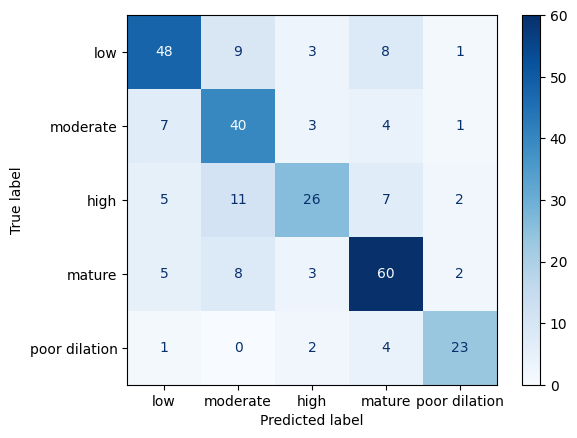

ROC-AUC: 0.9029

=== Phase: partial ===


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


[partial | Epoch 1/15 | Step 4/41] Step Loss: 0.7887
[partial | Epoch 1/15 | Step 9/41] Step Loss: 0.5018
[partial | Epoch 1/15 | Step 14/41] Step Loss: 0.7400
[partial | Epoch 1/15 | Step 19/41] Step Loss: 0.5866
[partial | Epoch 1/15 | Step 24/41] Step Loss: 0.6270
[partial | Epoch 1/15 | Step 29/41] Step Loss: 0.6149
[partial | Epoch 1/15 | Step 34/41] Step Loss: 0.5153
[partial | Epoch 1/15 | Step 39/41] Step Loss: 0.6076
Epoch [1/15], Train Loss: 0.6183, Acc: 0.7701, F1: 0.7688 | Val Loss: 0.6136, Acc: 0.7774, F1: 0.7795
[partial | Epoch 2/15 | Step 4/41] Step Loss: 0.3499
[partial | Epoch 2/15 | Step 9/41] Step Loss: 0.4494
[partial | Epoch 2/15 | Step 14/41] Step Loss: 0.3417
[partial | Epoch 2/15 | Step 19/41] Step Loss: 0.5279
[partial | Epoch 2/15 | Step 24/41] Step Loss: 0.4495
[partial | Epoch 2/15 | Step 29/41] Step Loss: 0.3653
[partial | Epoch 2/15 | Step 34/41] Step Loss: 0.3057
[partial | Epoch 2/15 | Step 39/41] Step Loss: 0.3457
Epoch [2/15], Train Loss: 0.3594, Acc:

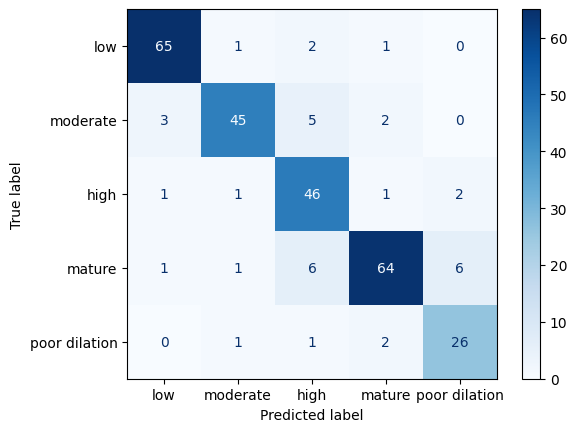

ROC-AUC: 0.9735

=== Phase: full ===


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


[full | Epoch 1/20 | Step 4/41] Step Loss: 0.0254
[full | Epoch 1/20 | Step 9/41] Step Loss: 0.0319
[full | Epoch 1/20 | Step 14/41] Step Loss: 0.0424
[full | Epoch 1/20 | Step 19/41] Step Loss: 0.0545
[full | Epoch 1/20 | Step 24/41] Step Loss: 0.0497
[full | Epoch 1/20 | Step 29/41] Step Loss: 0.1757
[full | Epoch 1/20 | Step 34/41] Step Loss: 0.0383
[full | Epoch 1/20 | Step 39/41] Step Loss: 0.0477
Epoch [1/20], Train Loss: 0.0544, Acc: 0.9843, F1: 0.9843 | Val Loss: 0.4657, Acc: 0.8693, F1: 0.8683
[full | Epoch 2/20 | Step 4/41] Step Loss: 0.0348
[full | Epoch 2/20 | Step 9/41] Step Loss: 0.0628
[full | Epoch 2/20 | Step 14/41] Step Loss: 0.0282
[full | Epoch 2/20 | Step 19/41] Step Loss: 0.0365
[full | Epoch 2/20 | Step 24/41] Step Loss: 0.0219
[full | Epoch 2/20 | Step 29/41] Step Loss: 0.0341
[full | Epoch 2/20 | Step 34/41] Step Loss: 0.0283
[full | Epoch 2/20 | Step 39/41] Step Loss: 0.0314
Epoch [2/20], Train Loss: 0.0417, Acc: 0.9900, F1: 0.9901 | Val Loss: 0.4743, Acc: 0.8

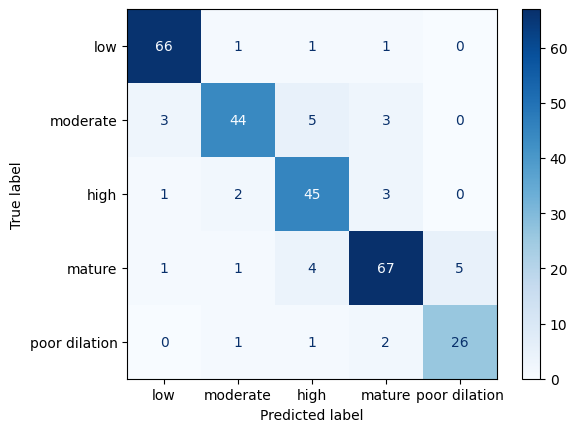

ROC-AUC: 0.9767


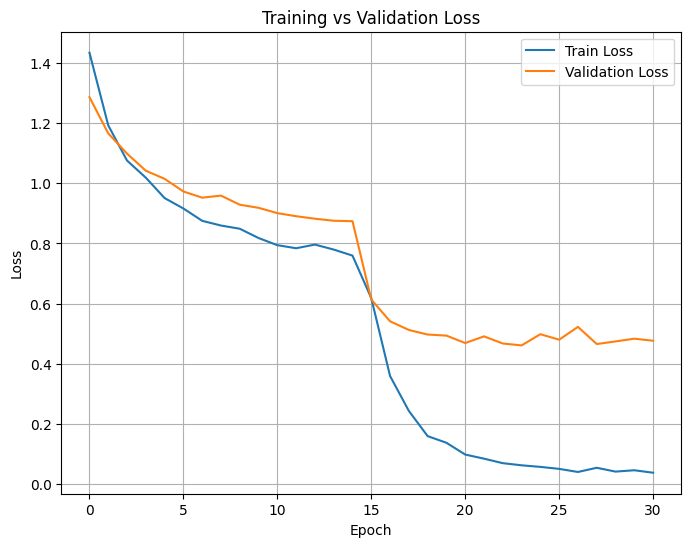


Training complete. Best models for each phase saved.


In [ ]:
model = progressive_training(train_loader, val_loader, num_classes=5)